<a href="https://colab.research.google.com/github/V-Pavan-Sastry/Pytorch/blob/main/MachineFailureClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mujtabamatin/dataset-for-machine-failure-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vpavansastry
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mujtabamatin/dataset-for-machine-failure-detection


100%|██████████| 25.1k/25.1k [00:00<00:00, 33.2MB/s]

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#setting the device
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cpu


In [23]:
#reading the data from the datset

data_df = pd.read_csv("/content/dataset-for-machine-failure-detection/machine_failure_dataset.csv")
data_df.head()

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,Mill,1
1,68.617357,54.623168,9.710963,25.698075,Lathe,0
2,76.476885,50.298152,8.415160,27.931972,Drill,1
3,85.230299,46.765316,9.384077,39.438438,Lathe,1
4,67.658466,53.491117,6.212771,32.782766,Drill,1


In [24]:
#Machine Type colum is in string format
data_df['Machine_Type'].unique()
""" It has 3 unique variables lets allot each a number
Mill ==> 0
Lathe ==> 1
Drill ==> 2
Others ==> 3 (if any)
"""
for index , machine in enumerate(data_df['Machine_Type']):
  if machine == 'Mill':
    data_df.loc[index, "Machine_Type"] = 0
  elif machine == 'Lathe':
    data_df.loc[index, "Machine_Type"] = 1
  elif machine == 'Drill':
    data_df.loc[index, "Machine_Type"] = 2
  else:
    data_df.loc[index, "Machine_Type"] = 3
data_df.head()


,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,74.967142,56.996777,8.649643,20.460962,0,1
1,68.617357,54.623168,9.710963,25.698075,1,0
2,76.476885,50.298152,8.415160,27.931972,2,1
3,85.230299,46.765316,9.384077,39.438438,1,1
4,67.658466,53.491117,6.212771,32.782766,2,1


In [25]:
#cross checking if that works
data_df['Machine_Type'].unique()

array([0, 1, 2], dtype=object)

In [29]:
data_df.dropna(inplace=True) #dropping any rows if no values in any columns
print(data_df.shape)

(1000, 6)


In [32]:
# Checking if data is eveny distributed evenly
data_df['Failure_Risk'].value_counts()
#Conclusion : The data is no that evenly distributed but let's work with what is available

,count
Failure_Risk,
0,700
1,300


In [34]:
#Normalization
original_df =data_df.copy()
Normalization_vals={}
for column in data_df.columns:
  Normalization_vals[column]=data_df[column].abs().max()
  data_df[column] = data_df[column]/Normalization_vals[column]
print(Normalization_vals)

{'Temperature': 108.5273149, 'Vibration': 65.96553784, 'Power_Usage': 17.85247541, 'Humidity': 46.21546485, 'Machine_Type': 2, 'Failure_Risk': 1}


In [35]:
data_df.head()

,Temperature,Vibration,Power_Usage,Humidity,Machine_Type,Failure_Risk
0,0.690767,0.864039,0.484507,0.442730,0.0,1.0
1,0.632259,0.828056,0.543956,0.556049,0.5,0.0
2,0.704679,0.762491,0.471372,0.604386,1.0,1.0
3,0.785335,0.708936,0.525646,0.853360,0.5,1.0
4,0.623423,0.810895,0.348006,0.709346,1.0,1.0


In [40]:
#creating test train val split
X=np.array(data_df.iloc[:,:-1]) # alll rows all cols except Failure Risk
Y=np.array(data_df.iloc[:,-1]) # Failure Risk is the classification label
X= X.astype(np.float32)
Y= Y.astype(np.float32)
# Test Train Split 70/30
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)
#splitting testing data in 2 halves for testing and validtaion 50/50
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test,test_size=0.5)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_val.shape,Y_val.shape)
#Checking if the splitting worked


(700, 5) (700,)
(150, 5) (150,)
(150, 5) (150,)


In [41]:
#Convert numpy arrays to torch dataset
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X,dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y,dtype = torch.float32).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,index):
    return self.X[index],self.Y[index]

train_data = dataset(X_train,Y_train)
test_data = dataset(X_test,Y_test)
validation_data =dataset(X_val,Y_val)

In [139]:
#HYPER PARMETERS
BATCH_SIZE=8
HIDDEN_NUERONS = 64
EPOCHS = 10

In [140]:
#Segmenting data into Batches
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
validation_dataloader = DataLoader(validation_data,batch_size=BATCH_SIZE,shuffle=True)

In [143]:
#Creating the model
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()
    self.input_layer = nn.Linear(X.shape[1],HIDDEN_NUERONS) #X.shape[1] = no of rows of dep vars
    self.linear= nn.Linear(HIDDEN_NUERONS,1)# output
    self.sigmoid =nn.Sigmoid() #activation function for binary classification
  def forward(self,x):
    x=self.input_layer(x)
    x=self.linear(x)
    x=self.sigmoid(x)
    return x

model = MyModel().to(device)
summary(model,(X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             384
            Linear-2                    [-1, 1]              65
           Sigmoid-3                    [-1, 1]               0
Total params: 449
Trainable params: 449
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [144]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(),lr=1e-3)

In [145]:
# Model Training
total_loss_train_plot = []
total_loss_validation_plot =[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_acc_train =0
  total_loss_train =0
  total_acc_validation =0
  total_loss_validation =0
  for data in train_dataloader:
    inputs,labels = data
    #print(inputs)
    #print(labels)
    predictions = model(inputs).squeeze(1)
    #print(predictions)
    batch_loss = criterion(predictions,labels)
    total_loss_train +=batch_loss.item()
    acc=(predictions.round()==labels).sum().item()
    total_acc_train+=acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    for inputs,labels in validation_dataloader:
      predictions = model(inputs).squeeze(1)
      batch_loss = criterion(predictions,labels)
      total_loss_validation +=batch_loss.item()
      acc=(predictions.round()==labels).sum().item()
      total_acc_validation +=acc
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_validation/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_data.__len__() *100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__() *100,4))
  print(f"""Epoch no. {epoch+1}
  Training Loss {round(total_loss_train/1000,4)}
  Validation loss {round(total_loss_validation/1000,4)}
  Training Accuracy {round(total_acc_train/train_data.__len__() *100,4)}
  Validation Accuracy {round(total_acc_validation/validation_data.__len__() *100,4)}""")
  print("="*35)


Epoch no. 1
  Training Loss 0.0558
  Validation loss 0.0112
  Training Accuracy 67.8571
  Validation Accuracy 73.3333
Epoch no. 2
  Training Loss 0.0555
  Validation loss 0.0111
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 3
  Training Loss 0.0552
  Validation loss 0.011
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 4
  Training Loss 0.0551
  Validation loss 0.0111
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 5
  Training Loss 0.0553
  Validation loss 0.011
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 6
  Training Loss 0.0551
  Validation loss 0.011
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 7
  Training Loss 0.0552
  Validation loss 0.0112
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 8
  Training Loss 0.0553
  Validation loss 0.011
  Training Accuracy 68.1429
  Validation Accuracy 73.3333
Epoch no. 9
  Training Loss 0.0551
  Validation loss 0.0113


In [146]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0
  for data in test_dataloader:
    inputs,labels = data
    predictions = model(inputs).squeeze(1)
    batch_loss =criterion(predictions,labels)
    total_loss_test+=batch_loss.item()
    acc=((predictions).round()==labels).sum().item()
    total_acc_test+=acc
  print(f"""Test Loss {round(total_loss_test/1000,4)}
  Test Accuracy {round(total_acc_test/test_data.__len__() *100,4)}""")

Test Loss 0.0109
  Test Accuracy 75.3333


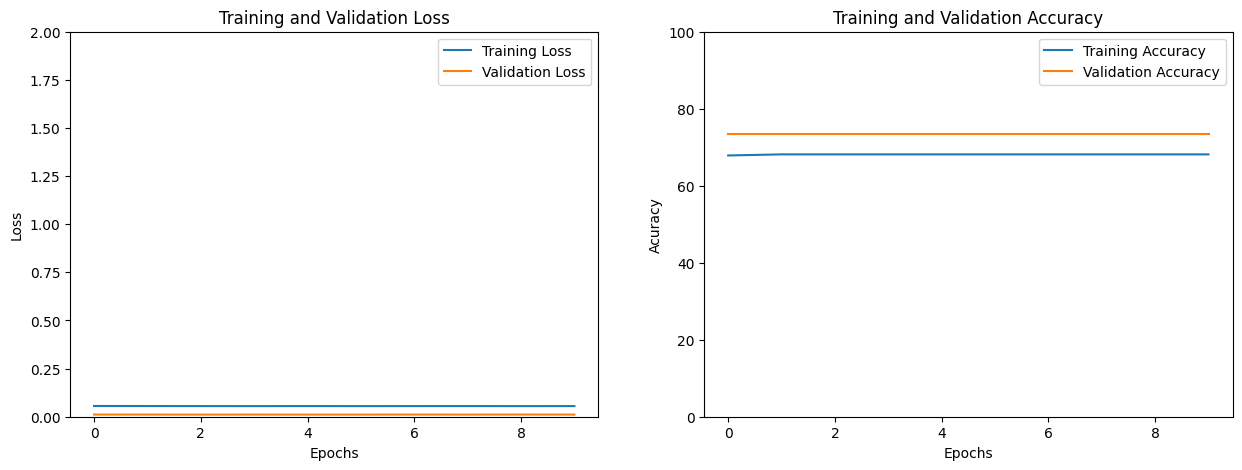

In [149]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label="Training Loss")
axs[0].plot(total_loss_validation_plot,label="Validation Loss")
axs[0].set_title("Training and Validation Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot,label="Training Accuracy")
axs[1].plot(total_acc_validation_plot,label="Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Acuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [138]:
Temperature=float(input("Enter the Temperature(deg cel) in Typical Range(108.5273149 37.5873266) ") )/ Normalization_vals['Temperature']
Vibration = float(input("Enter the Vibration in Typical Range(65.96553784 35.29805683) ") )/ Normalization_vals['Vibration']
Power_Usage=float(input("Enter the Power_Usage in Typical Range(17.85247541 3.960975688) ") )/ Normalization_vals['Power_Usage']
Humidity = float(input("Enter the Humidity in Typical Range(46.21546485 15.35275655) ") )/ Normalization_vals['Humidity']
Machine_Type = float(input("Select Machine Type {(1,Mill) , (2,Lathe) , (3,Drill)} ") )/ Normalization_vals['Machine_Type']
prediction =model(torch.tensor([Temperature,Vibration,Power_Usage,Humidity,Machine_Type],dtype=torch.float32).to(device)).item()
print(prediction,round(prediction))
if round(prediction) ==1:
  print("at high risk of failure")
else:
  print("at low risk of failure")

Enter the Temperature(deg cel) in Typical Range(108.5273149 37.5873266) 89.83746
Enter the Vibration in Typical Range(65.96553784 35.29805683) 60.3456
Enter the Power_Usage in Typical Range(17.85247541 3.960975688) 12.3546
Enter the Humidity in Typical Range(46.21546485 15.35275655) 23.43566
Select Machine Type {(1,Mill) , (2,Lathe) , (3,Drill)} 1
0.3170267939567566 0
at low risk of failure
